<a href="https://www.kaggle.com/code/mikedelong/python-dimension-reduction?scriptVersionId=141189538" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
from datetime import date
df = pd.read_csv(filepath_or_buffer='/kaggle/input/top-spotify-songs-2023/spotify-2023.csv', encoding='latin-1', thousands=',')
df['released']=df.apply(lambda x: pd.to_datetime(date(year=x['released_year'], month=x['released_month'], day=x['released_day'])),axis=1)
df = df.drop(columns=['released_year', 'released_month', 'released_day'])
df = df[df['streams'].str.isnumeric()]
df['streams'] = df['streams'].astype(int)
df['in_shazam_charts'] = df['in_shazam_charts'].fillna(value=0).astype(int)
df.head()

,track_name,artist(s)_name,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,released
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,553,147,141381703,43,263,45,10,...,B,Major,80,89,83,31,0,8,4,2023-07-14
1,LALA,Myke Towers,1,1474,48,133716286,48,126,58,14,...,C#,Major,71,61,74,7,0,10,4,2023-03-23
2,vampire,Olivia Rodrigo,1,1397,113,140003974,94,207,91,14,...,F,Major,51,32,53,17,0,31,6,2023-06-30
3,Cruel Summer,Taylor Swift,1,7858,100,800840817,116,207,125,12,...,A,Major,55,58,72,11,0,11,15,2019-08-23
4,WHERE SHE GOES,Bad Bunny,1,3133,50,303236322,84,133,87,15,...,A,Minor,65,23,80,14,63,11,6,2023-05-18


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 952
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   track_name            952 non-null    object        
 1   artist(s)_name        952 non-null    object        
 2   artist_count          952 non-null    int64         
 3   in_spotify_playlists  952 non-null    int64         
 4   in_spotify_charts     952 non-null    int64         
 5   streams               952 non-null    int64         
 6   in_apple_playlists    952 non-null    int64         
 7   in_apple_charts       952 non-null    int64         
 8   in_deezer_playlists   952 non-null    int64         
 9   in_deezer_charts      952 non-null    int64         
 10  in_shazam_charts      952 non-null    int64         
 11  bpm                   952 non-null    int64         
 12  key                   857 non-null    object        
 13  mode                

In [3]:
df.nunique()

track_name              942
artist(s)_name          644
artist_count              8
in_spotify_playlists    878
in_spotify_charts        82
streams                 948
in_apple_playlists      234
in_apple_charts         172
in_deezer_playlists     348
in_deezer_charts         34
in_shazam_charts        198
bpm                     124
key                      11
mode                      2
danceability_%           72
valence_%                94
energy_%                 80
acousticness_%           98
instrumentalness_%       39
liveness_%               68
speechiness_%            48
released                476
dtype: int64

<Axes: ylabel='Frequency'>

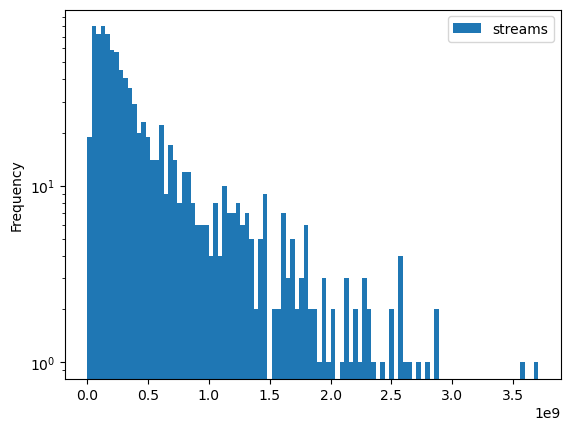

In [4]:
df['streams'].plot.hist(bins=100, legend=True, log=True)

We need to do some dimension reduction

In [5]:
from plotly.express import scatter
from sklearn.manifold import TSNE
df[['pct_x', 'pct_y']] =  TSNE(n_components=2, verbose=1, random_state=2023,).fit_transform(X=df[[item for item in df.columns if '%' in item]])
scatter(data_frame=df, x='pct_x', y='pct_y', hover_name='track_name').show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 952 samples in 0.001s...
[t-SNE] Computed neighbors for 952 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 952 / 952
[t-SNE] Mean sigma: 11.929485
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.419136
[t-SNE] KL divergence after 1000 iterations: 1.024556


We have some outliers on both the high and low side, so we take the log and remove a couple of low values to get a good spread of colors for the streams.

In [6]:
from numpy import log
from plotly.express import scatter
df['log_streams'] = log(df['streams'])
df = df[df['log_streams'] > 16]
scatter(data_frame=df, x='pct_x', y='pct_y', hover_name='track_name', color='log_streams').show()

I suspect what we're learning here is that while the percentages above will help tell us what kind of playlist a song is included in it won't tell us how many streams it gets.

<Axes: >

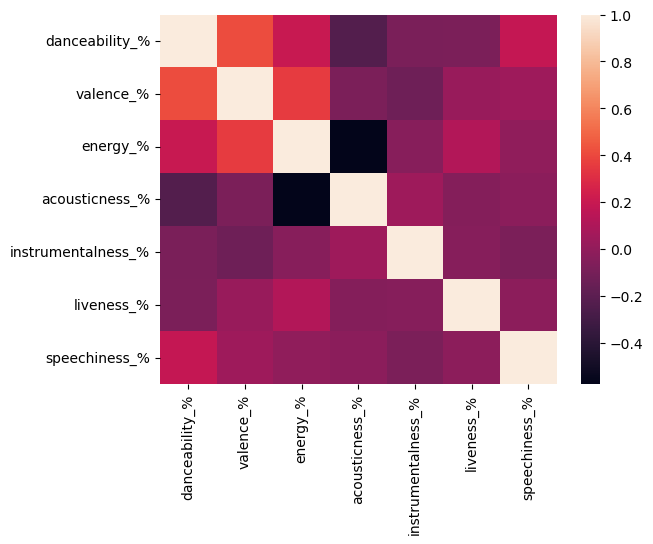

In [7]:
from seaborn import heatmap
heatmap(data=df[[item for item in df.columns if '%' in item]].corr())

Apart from acousticness and energy it seems like each of these quantities measures something that is positively correlated.

<Axes: >

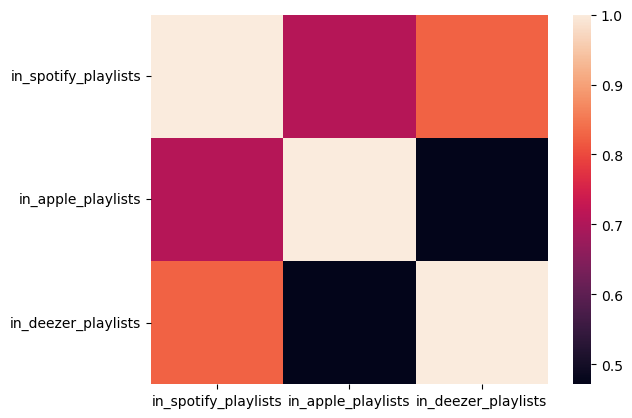

In [8]:
heatmap(data=df[[item for item in df.columns if 'playlist' in item]].corr())

<Axes: >

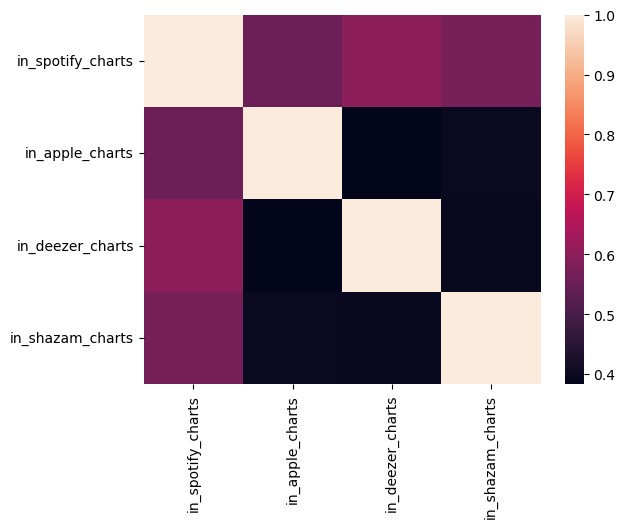

In [9]:
heatmap(data=df[[item for item in df.columns if 'chart' in item]].corr())

In [10]:
df[['chart_x', 'chart_y']] =  TSNE(n_components=2, verbose=1, random_state=2023,).fit_transform(X=df[[item for item in df.columns if 'chart' in item]])
df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 950 samples in 0.001s...
[t-SNE] Computed neighbors for 950 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 950 / 950
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.149082
[t-SNE] KL divergence after 1000 iterations: 0.450773


,track_name,artist(s)_name,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,...,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,released,pct_x,pct_y,log_streams,chart_x,chart_y
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,553,147,141381703,43,263,45,10,...,31,0,8,4,2023-07-14,-0.850486,28.537729,18.766974,38.537079,-14.823696
1,LALA,Myke Towers,1,1474,48,133716286,48,126,58,14,...,7,0,10,4,2023-03-23,-19.794779,2.038510,18.711231,33.148399,-12.337811
2,vampire,Olivia Rodrigo,1,1397,113,140003974,94,207,91,14,...,17,0,31,6,2023-06-30,7.730024,-17.113106,18.757181,39.002552,-15.304890
3,Cruel Summer,Taylor Swift,1,7858,100,800840817,116,207,125,12,...,11,0,11,15,2019-08-23,-20.718630,-18.440567,20.501173,36.067078,-13.365971
4,WHERE SHE GOES,Bad Bunny,1,3133,50,303236322,84,133,87,15,...,14,63,11,6,2023-05-18,18.767252,-25.010412,19.530023,33.988808,-12.717566


In [11]:
scatter(data_frame=df, x='chart_x', y='chart_y', hover_name='track_name', color='log_streams').show()

In [12]:
df[['playlist_x', 'playlist_y']] =  TSNE(n_components=2, verbose=1, random_state=2023,).fit_transform(X=df[[item for item in df.columns if 'playlist' in item]])
df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 950 samples in 0.001s...
[t-SNE] Computed neighbors for 950 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 950 / 950
[t-SNE] Mean sigma: 59.707074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.284302
[t-SNE] KL divergence after 1000 iterations: 0.207387


,track_name,artist(s)_name,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,...,liveness_%,speechiness_%,released,pct_x,pct_y,log_streams,chart_x,chart_y,playlist_x,playlist_y
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,553,147,141381703,43,263,45,10,...,8,4,2023-07-14,-0.850486,28.537729,18.766974,38.537079,-14.823696,-31.041016,1.738999
1,LALA,Myke Towers,1,1474,48,133716286,48,126,58,14,...,10,4,2023-03-23,-19.794779,2.038510,18.711231,33.148399,-12.337811,-1.198318,12.516752
2,vampire,Olivia Rodrigo,1,1397,113,140003974,94,207,91,14,...,31,6,2023-06-30,7.730024,-17.113106,18.757181,39.002552,-15.304890,-1.688556,15.193550
3,Cruel Summer,Taylor Swift,1,7858,100,800840817,116,207,125,12,...,11,15,2019-08-23,-20.718630,-18.440567,20.501173,36.067078,-13.365971,26.378187,5.333099
4,WHERE SHE GOES,Bad Bunny,1,3133,50,303236322,84,133,87,15,...,11,6,2023-05-18,18.767252,-25.010412,19.530023,33.988808,-12.717566,4.501244,-26.360064


In [13]:
scatter(data_frame=df, x='playlist_x', y='playlist_y', hover_name='track_name', color='log_streams').show()

This is not surprising as we expect inclusion in numbers of playlists to be highly correlated with total streams. People tend to play songs from playlists.